In [144]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb

#### Output file

In [145]:
sourceFile = open("gpu_logs/ensemble_our.txt", 'w')

### Load the data

In [146]:
df = pd.read_pickle("../datasets/df_location_our_dataset.pkl")
number_of_houses = 7
num_samples_per_house = 35032
df.reset_index(drop=True, inplace=True)
df = df.iloc[:, [0, 2, 1]]
df['Time'] =  pd.to_datetime(df['Time'])
df

,Time,Location,Energy
0,2021-11-01 00:15:00,PT41CV,0.028
1,2021-11-01 00:30:00,PT41CV,0.080
2,2021-11-01 00:45:00,PT41CV,0.092
3,2021-11-01 01:00:00,PT41CV,0.040
4,2021-11-01 01:15:00,PT41CV,0.076
...,...,...,...
245219,2022-10-31 23:00:00,PT87ZW,0.368
245220,2022-10-31 23:15:00,PT87ZW,0.396
245221,2022-10-31 23:30:00,PT87ZW,0.356
245222,2022-10-31 23:45:00,PT87ZW,0.392


### Auxiliary functions

In [147]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    wape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    r2 = r2_score(actuals, preds)
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.4f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [148]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)


def last_energy_points(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = pd.DataFrame(df[number_timesteps:])
    y = y['Energy']
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    return X, y

def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe

In [149]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

### Cross Validate

In [150]:
#scores = validate(model, X_train, y_train)
#cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
#cv_r2 = np.round(scores['test_r2'].mean(),5)
#print("CV MSE: {} ".format(cv_mse))
#print("CV R2: {} ".format(cv_r2))
#metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

## Leave 10 houses for test (demonstration)

In [151]:
number_of_timesteps = 12

In [152]:
locations = np.random.choice(df['Location'].unique(), size=2, replace=False)
locations

array(['PT17RW', 'PT69QG'], dtype=object)

In [153]:
df_new = last_energy_points_full(df, number_of_timesteps, num_samples_per_house)
df_new

,Time,Location,Energy_15,Energy_30,Energy_45,Energy_60,Energy_75,Energy_90,Energy_105,Energy_120,Energy_135,Energy_150,Energy_165,Energy_180,Energy
0,2021-11-01 03:15:00,PT41CV,0.044,0.048,0.116,0.128,0.100,0.180,0.124,0.076,0.040,0.092,0.080,0.028,0.116
1,2021-11-01 03:30:00,PT41CV,0.116,0.044,0.048,0.116,0.128,0.100,0.180,0.124,0.076,0.040,0.092,0.080,0.048
2,2021-11-01 03:45:00,PT41CV,0.048,0.116,0.044,0.048,0.116,0.128,0.100,0.180,0.124,0.076,0.040,0.092,0.028
3,2021-11-01 04:00:00,PT41CV,0.028,0.048,0.116,0.044,0.048,0.116,0.128,0.100,0.180,0.124,0.076,0.040,0.112
4,2021-11-01 04:15:00,PT41CV,0.112,0.028,0.048,0.116,0.044,0.048,0.116,0.128,0.100,0.180,0.124,0.076,0.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245135,2022-10-31 23:00:00,PT87ZW,0.392,0.564,0.632,0.592,0.512,0.512,0.504,0.564,0.664,0.608,0.592,0.696,0.368
245136,2022-10-31 23:15:00,PT87ZW,0.368,0.392,0.564,0.632,0.592,0.512,0.512,0.504,0.564,0.664,0.608,0.592,0.396
245137,2022-10-31 23:30:00,PT87ZW,0.396,0.368,0.392,0.564,0.632,0.592,0.512,0.512,0.504,0.564,0.664,0.608,0.356
245138,2022-10-31 23:45:00,PT87ZW,0.356,0.396,0.368,0.392,0.564,0.632,0.592,0.512,0.512,0.504,0.564,0.664,0.392


In [154]:
df_new.isna().sum()

Time          0
Location      0
Energy_15     0
Energy_30     0
Energy_45     0
Energy_60     0
Energy_75     0
Energy_90     0
Energy_105    0
Energy_120    0
Energy_135    0
Energy_150    0
Energy_165    0
Energy_180    0
Energy        0
dtype: int64

In [155]:
def test_leave_house_out(df, estimator, number_timesteps, num_houses_test, locations, filename):
    df_new = last_energy_points_full(df, number_timesteps, num_samples_per_house)
    df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
    df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5,6]).astype(int)
    df_new['Hour'] = df_new['Time'].dt.hour
    test = df_new[df_new['Location'].isin(locations)]
    train = df_new[~df_new['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Predict  10 folds with 10 random houses for test

### XGBoost

In [156]:
num_houses_test = 2

In [157]:
locations = []
for i in range(10):
    np.random.seed(i*4)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['PT87ZW', 'PT15VP'], dtype=object),
 array(['PT43QL', 'PT87ZW'], dtype=object),
 array(['PT15VP', 'PT41CV'], dtype=object),
 array(['PT43QL', 'PT17RW'], dtype=object),
 array(['PT15VP', 'PT43QL'], dtype=object),
 array(['PT87ZW', 'PT41CV'], dtype=object),
 array(['PT43QL', 'PT87ZW'], dtype=object),
 array(['PT17RW', 'PT15VP'], dtype=object),
 array(['PT87ZW', 'PT44AL'], dtype=object),
 array(['PT69QG', 'PT43QL'], dtype=object)]

### Linear Regression

In [158]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)


### XGBoost

In [159]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)
Train set:  (175100, 18)
Test set:  (70040, 18)


### Random Forest

In [160]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (175100, 18)
Test set:  (70040, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [161]:
print("\n\n\n", file=sourceFile)

In [162]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [163]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [164]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

### Feature Importance

In [165]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: 4.25152
Feature: 1, Score: -0.55912
Feature: 2, Score: 0.63230
Feature: 3, Score: -0.08371
Feature: 4, Score: 0.14607
Feature: 5, Score: 0.17300
Feature: 6, Score: 0.30564
Feature: 7, Score: -0.13415
Feature: 8, Score: 0.18311
Feature: 9, Score: 0.01203
Feature: 10, Score: 0.07552
Feature: 11, Score: 0.16334
Feature: 12, Score: -0.00161
Feature: 13, Score: 0.00177
Feature: 14, Score: 0.04158
XGBoost

Feature: 0, Score: 0.57887
Feature: 1, Score: 0.04766
Feature: 2, Score: 0.03708
Feature: 3, Score: 0.02940
Feature: 4, Score: 0.02419
Feature: 5, Score: 0.02312
Feature: 6, Score: 0.02708
Feature: 7, Score: 0.03917
Feature: 8, Score: 0.03014
Feature: 9, Score: 0.02579
Feature: 10, Score: 0.03026
Feature: 11, Score: 0.02359
Feature: 12, Score: 0.02920
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.05445


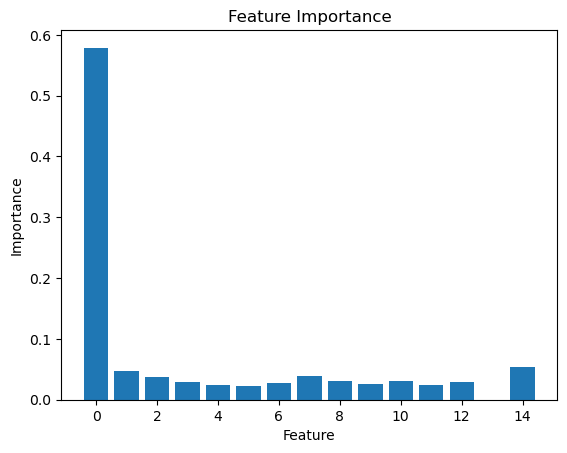

In [166]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

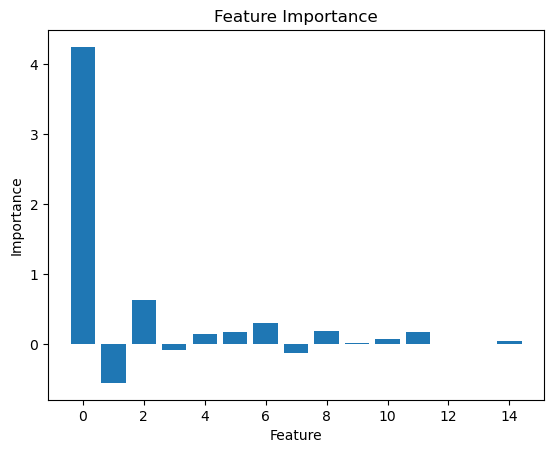

In [167]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [168]:
sourceFile.close()